Video file: Dataset/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi
Total frames: 123
FPS: 25.0
Resolution: 320 x 240


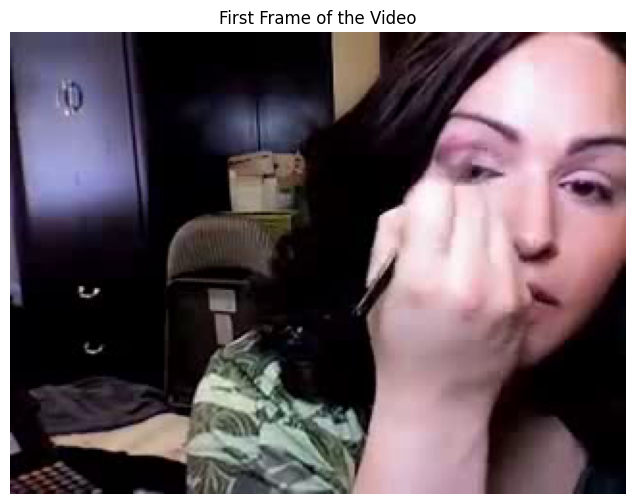

In [56]:
import cv2
import matplotlib.pyplot as plt

# Specify a sample video file path (adjust the path if needed)
sample_video = 'Dataset/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi'

# Open the video file
cap = cv2.VideoCapture(sample_video)
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    # Retrieve video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print("Video file:", sample_video)
    print("Total frames:", frame_count)
    print("FPS:", fps)
    print("Resolution: {} x {}".format(width, height))
    
    # Read the first frame
    ret, frame = cap.read()
    if ret:
        # Convert color from BGR to RGB for display purposes
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8,6))
        plt.imshow(frame_rgb)
        plt.title("First Frame of the Video")
        plt.axis('off')
        plt.show()
    else:
        print("Error: Could not read the first frame.")
    
    cap.release()


In [57]:
def load_video(video_path):
    """
    Loads a video file and returns a video tensor.
    The video tensor shape will be (num_frames, height, width, channels).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    
    # Convert frames list to a tensor (numpy array)
    import numpy as np
    video_tensor = np.array(frames)  # shape: (num_frames, height, width, channels)
    return video_tensor

# Test the function by loading a video and printing its shape
video_tensor = load_video(sample_video)
print("Loaded video shape:", video_tensor.shape)


Loaded video shape: (123, 240, 320, 3)


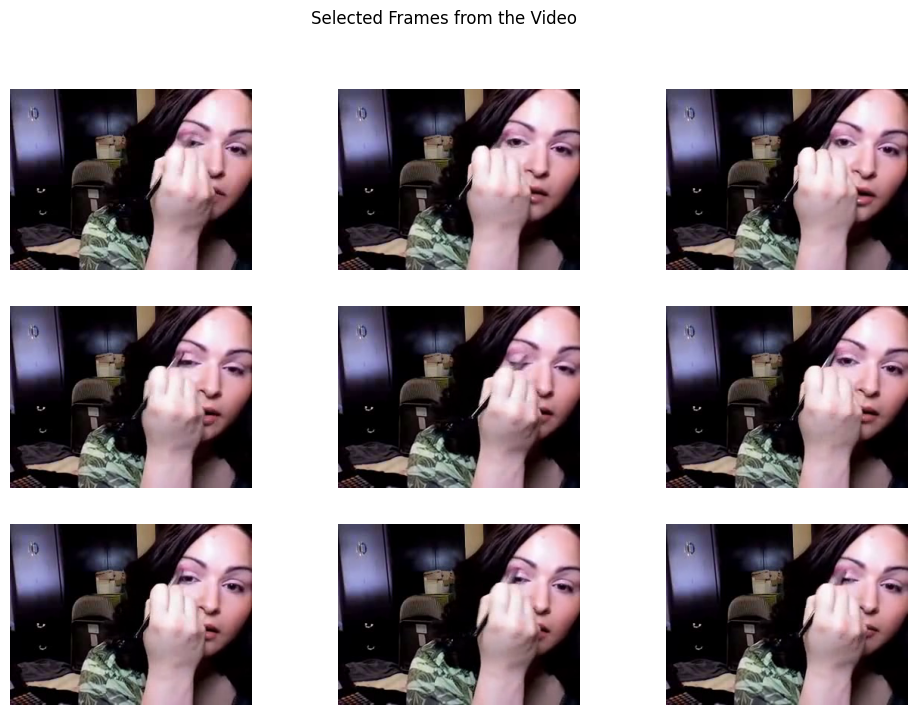

In [58]:
import matplotlib.pyplot as plt

def display_frames(video_tensor, num_frames=9):
    """
    Displays a grid of frames from the video tensor.
    """
    total_frames = video_tensor.shape[0]
    interval = max(total_frames // num_frames, 1)
    
    selected_frames = video_tensor[::interval][:num_frames]
    
    # Calculate grid size
    grid_size = int(num_frames**0.5)
    if grid_size * grid_size < num_frames:
        grid_size += 1
    
    plt.figure(figsize=(12, 8))
    for i, frame in enumerate(selected_frames):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(frame)
        plt.axis('off')
    plt.suptitle("Selected Frames from the Video")
    plt.show()

# Display frames from the loaded video
display_frames(video_tensor, num_frames=9)


In [59]:
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

In [60]:
# Configuration
FRAMES_PER_VIDEO = 30  # Number of frames per video clip
IMG_HEIGHT, IMG_WIDTH = 64, 64  #Frame dimensions
BATCH_SIZE = 8
EPOCHS = 3
NUM_CLASSES = len(os.listdir("Dataset/train"))  # Automatically get class count

In [61]:
def get_video_paths_and_labels(base_dir):
    classes = sorted(os.listdir(base_dir))
    video_paths, labels = [], []
    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        for video_file in os.listdir(class_dir):
            video_paths.append(os.path.join(class_dir, video_file))
            labels.append(class_name)
    return video_paths, labels

train_paths, train_labels = get_video_paths_and_labels("Dataset/train")
val_paths, val_labels = get_video_paths_and_labels("Dataset/val")
test_paths, test_labels = get_video_paths_and_labels("Dataset/test")

In [62]:
# Add this check before label encoding
train_classes = set(os.listdir("Dataset/train"))
val_classes = set(os.listdir("Dataset/val"))
test_classes = set(os.listdir("Dataset/test"))

assert train_classes == val_classes == test_classes, "Class mismatch between splits"

In [63]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

In [64]:
# Convert to int32 explicitly after encoding
train_labels = le.fit_transform(train_labels).astype('int32')
val_labels = le.transform(val_labels).astype('int32')
test_labels = le.transform(test_labels).astype('int32')

In [65]:
def process_video(path, label):
    cap = cv2.VideoCapture(path.numpy().decode('utf-8'))
    frames = []
    for _ in range(FRAMES_PER_VIDEO):
        ret, frame = cap.read()
        frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))/255.0 if ret else np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
        frames.append(frame)
    cap.release()
    return np.array(frames, dtype=np.float32), np.int32(label)  # Explicit cast

def tf_process_video(path, label):
    video, label = tf.py_function(
        process_video,
        [path, label],
        (tf.float32, tf.int32)  # Ensure output dtype matches
    )
    video.set_shape((FRAMES_PER_VIDEO, IMG_HEIGHT, IMG_WIDTH, 3))
    label.set_shape(())
    return video, label

In [66]:
# Get paths and labels
train_paths, train_labels = get_video_paths_and_labels("Dataset/train")
val_paths, val_labels = get_video_paths_and_labels("Dataset/val")

# Encode with int32 conversion
le = LabelEncoder()
train_labels = le.fit_transform(train_labels).astype('int32')
val_labels = le.transform(val_labels).astype('int32')

In [67]:
print(f"Label dtype: {train_labels.dtype}")  # Should show int32

Label dtype: int32


In [68]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(tf_process_video).batch(BATCH_SIZE).prefetch(2)

In [69]:
def create_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(tf_process_video, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_paths, train_labels)
val_ds = create_dataset(val_paths, val_labels)
test_ds = create_dataset(test_paths, test_labels)

In [70]:
model = tf.keras.Sequential([
    layers.Input(shape=(FRAMES_PER_VIDEO, IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # 3D Convolutional Blocks
    layers.Conv3D(16, (3, 3, 3), activation='relu'),
    layers.MaxPool3D((2, 2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv3D(32, (3, 3, 3), activation='relu'),
    layers.MaxPool3D((2, 2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv3D(64, (3, 3, 3), activation='relu'),
    layers.MaxPool3D((2, 2, 2)),
    layers.BatchNormalization(),
    
    # Classifier
    layers.GlobalAveragePooling3D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [71]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/3
1257/1257 [==============================] - 112s 89ms/step - loss: 4.8584 - accuracy: 0.0062 - val_loss: 4.6465 - val_accuracy: 0.0149
Epoch 2/3
1257/1257 [==============================] - 95s 75ms/step - loss: 4.4585 - accuracy: 0.0143 - val_loss: 4.6282 - val_accuracy: 0.0197
Epoch 3/3
1257/1257 [==============================] - 94s 75ms/step - loss: 4.2131 - accuracy: 0.0108 - val_loss: 4.6185 - val_accuracy: 0.0203


In [72]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

216/216 [==============================] - 16s 74ms/step - loss: 4.6200 - accuracy: 0.0203
Test Accuracy: 2.03%


# 0-)IMPORTS

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from collections import Counter
import seaborn as sns

# Configuration
FRAMES_PER_VIDEO = 30
IMG_HEIGHT, IMG_WIDTH = 64, 64
BATCH_SIZE = 8
EPOCHS = 10
NUM_CLASSES = len(os.listdir("Dataset/train"))

In [2]:
gpus = tf.config.list_physical_devices('GPU')

tf.config.set_visible_devices(gpus[0], 'GPU')

from tensorflow.python.client import device_lib
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')), "\n")

# Tüm cihazları listele ve her cihazın türünü yazdır
local_devices = device_lib.list_local_devices()

for device in local_devices:
    print(f"Device Name: {device.name}")
    print(f"Device Type: {device.device_type}")
    print(f"Device Description: {device.physical_device_desc}")
    print("-" * 40)


TensorFlow Version: 2.10.0
Num GPUs Available:  2 

Device Name: /device:CPU:0
Device Type: CPU
Device Description: 
----------------------------------------
Device Name: /device:GPU:0
Device Type: GPU
Device Description: device: 0, name: DML, pci bus id: <undefined>
----------------------------------------
Device Name: /device:GPU:1
Device Type: GPU
Device Description: device: 1, name: DML, pci bus id: <undefined>
----------------------------------------


# 1) Data Reading and Inspection

Video Properties:
- Frames: 123
- FPS: 25.0
- Resolution: 320x240


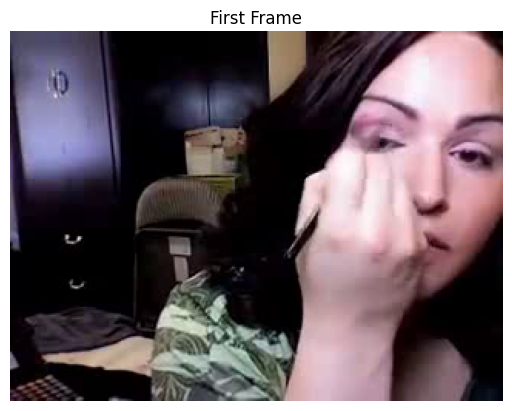

In [2]:
# Cell 1.1: Sample Video Inspection
def inspect_sample_video(sample_path):
    cap = cv2.VideoCapture(sample_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"Video Properties:\n- Frames: {frame_count}\n- FPS: {fps}\n- Resolution: {width}x{height}")
    
    # Read and display first frame
    ret, frame = cap.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title("First Frame")
        plt.axis('off')
        plt.show()
    
    cap.release()

sample_video = 'Dataset/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi'
inspect_sample_video(sample_video)

# 2) Data Visualization

In [3]:
# Cell 2.0: Data Loading
def get_video_paths_and_labels(base_dir):
    classes = sorted(os.listdir(base_dir))
    video_paths, labels = [], []
    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        for video_file in os.listdir(class_dir):
            video_paths.append(os.path.join(class_dir, video_file))
            labels.append(class_name)
    return video_paths, labels

# Load paths and labels
train_paths, train_labels = get_video_paths_and_labels("Dataset/train")
val_paths, val_labels = get_video_paths_and_labels("Dataset/val")
test_paths, test_labels = get_video_paths_and_labels("Dataset/test")

In [4]:
# Cell 2.1: Label Encoding
le = LabelEncoder()
train_labels = le.fit_transform(train_labels).astype('int32')
val_labels = le.transform(val_labels).astype('int32')
test_labels = le.transform(test_labels).astype('int32')
class_names = le.classes_  # Get ordered class names from LabelEncoder

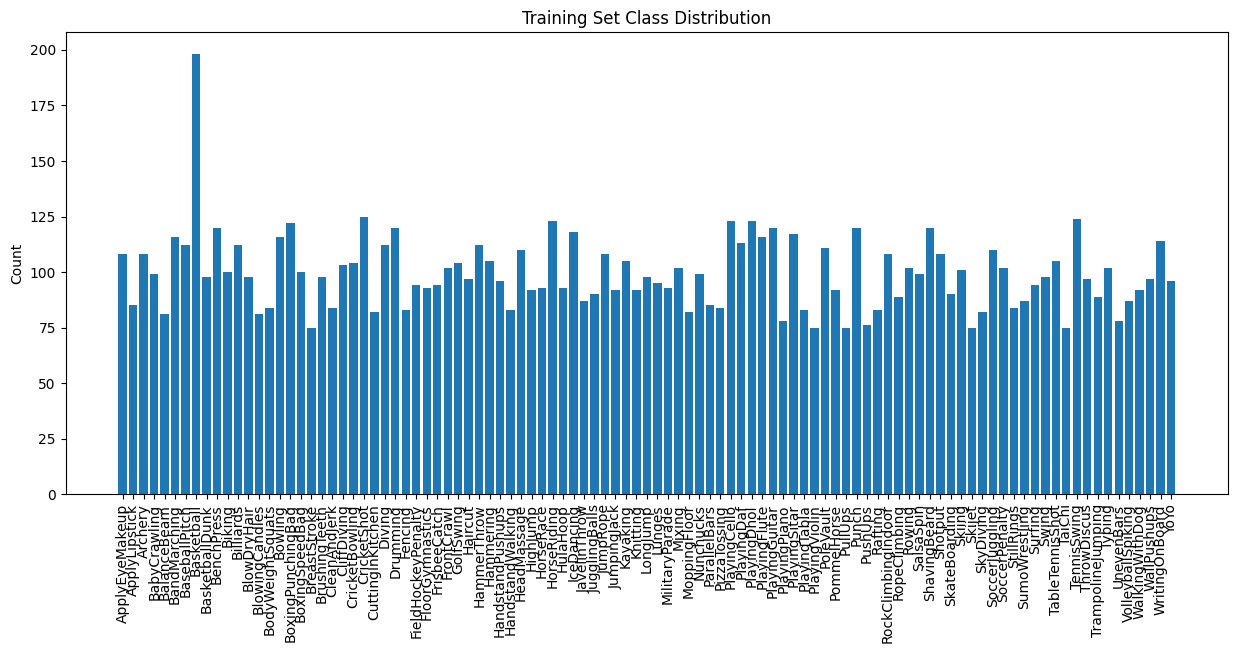

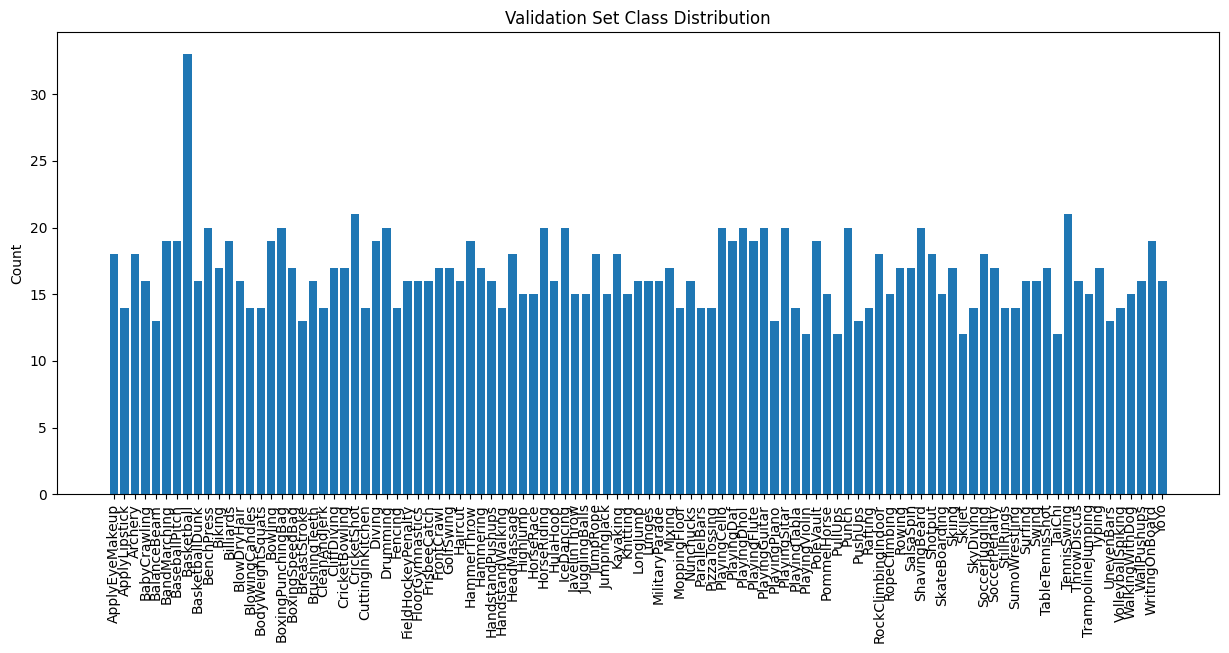

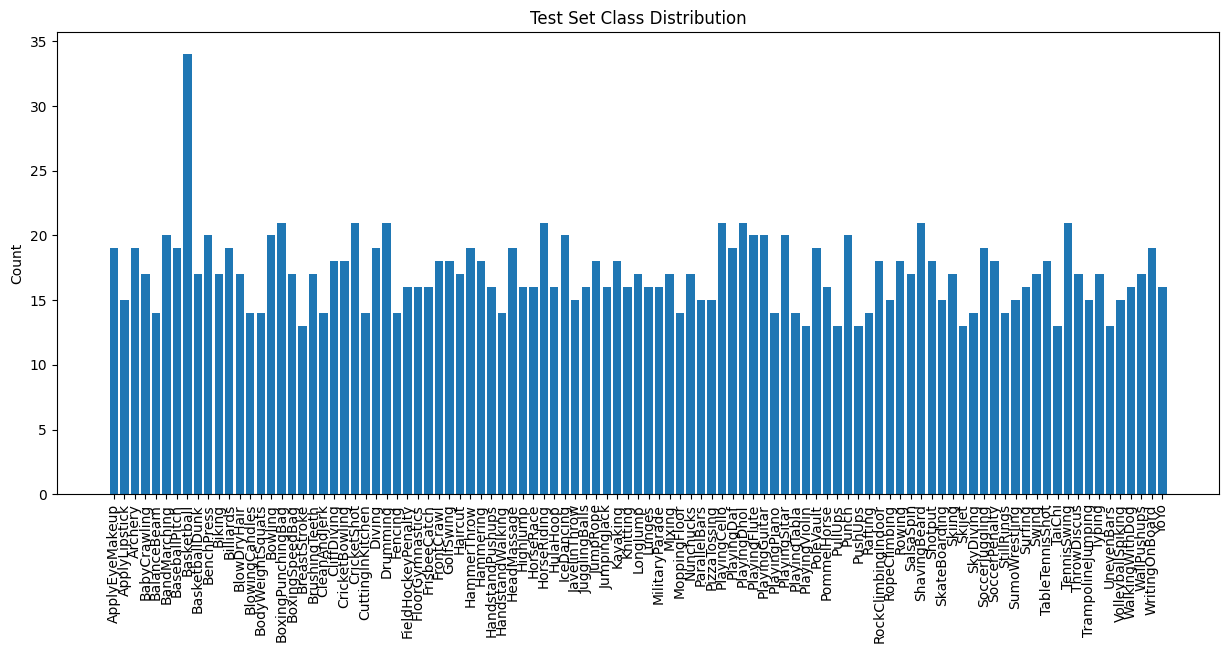

In [5]:
# Cell 2.2: Class Distribution Visualization
def plot_class_distribution(title, labels, class_names):
    label_counts = Counter(labels)
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[0])
    labels_idx, counts = zip(*sorted_labels)
    
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(counts)), counts, tick_label=class_names)
    plt.title(f'{title} Class Distribution')
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.show()

plot_class_distribution("Training Set", train_labels, class_names)
plot_class_distribution("Validation Set", val_labels, class_names)
plot_class_distribution("Test Set", test_labels, class_names)

# 3) Modeling


In [6]:
# Cell 3.1: Enhanced Model Architecture
def create_3dcnn_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(FRAMES_PER_VIDEO, IMG_HEIGHT, IMG_WIDTH, 3)),
        
        # Conv-Pool Blocks
        layers.Conv3D(32, (3, 3, 3), activation='relu'),
        layers.MaxPool3D((1, 2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv3D(64, (3, 3, 3), activation='relu'),
        layers.MaxPool3D((2, 2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv3D(128, (3, 3, 3), activation='relu'),
        layers.MaxPool3D((2, 2, 2)),
        layers.BatchNormalization(),
        
        # Temporal Modeling
        layers.TimeDistributed(layers.GlobalAveragePooling2D()),
        layers.Bidirectional(layers.LSTM(64)),
        
        # Classifier
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

model = create_3dcnn_model()

In [7]:
# Cell 3.2: Video Processing Functions
def process_video(path, label):
    cap = cv2.VideoCapture(path.numpy().decode('utf-8'))
    frames = []
    for _ in range(FRAMES_PER_VIDEO):
        ret, frame = cap.read()
        frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))/255.0 if ret else np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
        frames.append(frame)
    cap.release()
    return np.array(frames, dtype=np.float32), np.int32(label)

def tf_process_video(path, label):
    video, label = tf.py_function(
        process_video,
        [path, label],
        (tf.float32, tf.int32)
    )
    video.set_shape((FRAMES_PER_VIDEO, IMG_HEIGHT, IMG_WIDTH, 3))
    label.set_shape(())
    return video, label

# Dataset Creation
def create_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(
        lambda path, label: tf_process_video(path, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets after label encoding
train_ds = create_dataset(train_paths, train_labels)
val_ds = create_dataset(val_paths, val_labels)
test_ds = create_dataset(test_paths, test_labels)

# Verify dataset shapes
print("Train dataset element spec:", train_ds.element_spec)
print("Validation dataset element spec:", val_ds.element_spec)

Train dataset element spec: (TensorSpec(shape=(None, 30, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation dataset element spec: (TensorSpec(shape=(None, 30, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [8]:
# Cell 3.3: Correct Model Compilation with Sparse Metrics
#from tensorflow.keras.metrics import SparseCategoricalPrecision, SparseCategoricalRecall

class SparseMacroPrecision(tf.keras.metrics.Metric):
    def __init__(self, name='precision', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.cast(y_true, tf.int32)
        
        # Calculate confusion matrix
        cm = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
        
        # Calculate TP, FP, FN per class
        tp = tf.linalg.diag_part(cm)
        fp = tf.reduce_sum(cm, axis=0) - tp
        fn = tf.reduce_sum(cm, axis=1) - tp
        
        # Sum across all classes
        self.true_positives.assign_add(tf.reduce_sum(tp))
        self.false_positives.assign_add(tf.reduce_sum(fp))
        self.false_negatives.assign_add(tf.reduce_sum(fn))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        return precision

    def reset_state(self):
        self.true_positives.assign(0.)
        self.false_positives.assign(0.)
        self.false_negatives.assign(0.)

class SparseMacroRecall(SparseMacroPrecision):
    def __init__(self, name='recall', **kwargs):
        super().__init__(name=name, **kwargs)
        
    def result(self):
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return recall

METRICS = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc'),
    SparseMacroPrecision(),
    SparseMacroRecall()
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=METRICS
)

In [9]:
# Cell 3.4: Training with Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[CudnnRNN]]
	 [[sequential/bidirectional/forward_lstm/PartitionedCall]]
	 [[confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/pivot_f/_12/_45]]
  (1) INVALID_ARGUMENT:  No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[CudnnRNN]]
	 [[sequential/bidirectional/forward_lstm/PartitionedCall]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_6888]

In [13]:
# Check system configuration for AMD/DirectML users
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Using DirectML:", 'directml' in tf.config.list_physical_devices('GPU')[0].device_type.lower())

try:
    build_info = tf.sysconfig.get_build_info()
    print("CUDA Available:", 'cuda' in build_info)
    print("cuDNN Version:", build_info.get('cudnn_version', 'Not Available - Using DirectML'))
except AttributeError:
    print("\nDirectML Configuration:")
    print("TensorFlow Build Version:", tf.__version__)
    print("Note: DirectML backend doesn't use CUDA/cuDNN")
    print("Verify DirectML installation with:")
    print(" - Check GPU visibility: !dml::tools::dxdiag")
    print(" - Test basic GPU ops: !python -c \"import tensorflow as tf; print(tf.add([1,2], [3,4]))\"")



Num GPUs Available: 2
Using DirectML: False
CUDA Available: False
cuDNN Version: Not Available - Using DirectML


# 4) Model Evaluation

KeyError: 'acc'

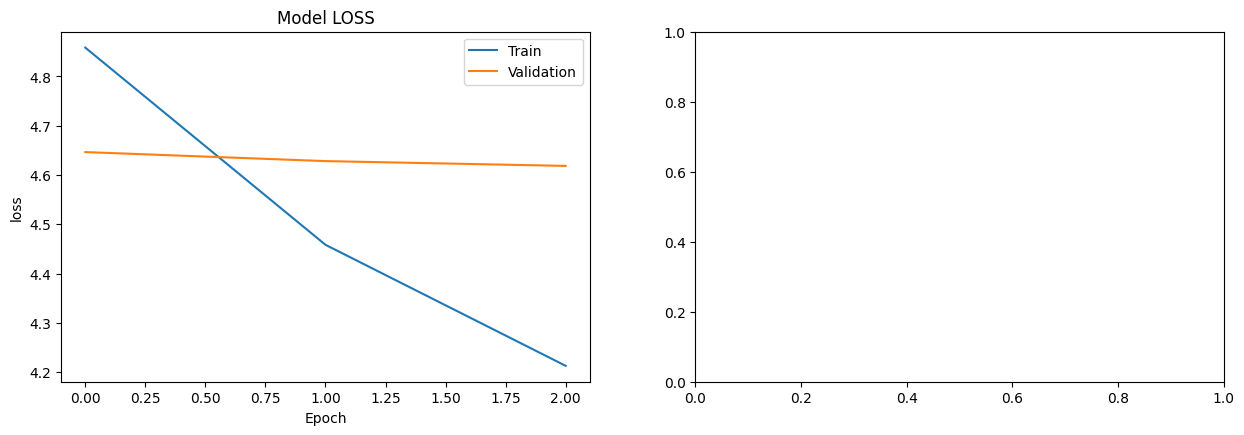

In [ ]:
# Cell 4.1: Training Metrics Visualization
def plot_training_history(history):
    metrics = ['loss', 'acc', 'precision', 'recall']
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(f'Model {metric.upper()}')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Cell 4.2: Comprehensive Evaluation
def evaluate_model(model, test_ds, class_names):
    # Test set evaluation
    test_results = model.evaluate(test_ds)
    print(f"Test Accuracy: {test_results[1]:.2%}")
    print(f"Top-3 Accuracy: {test_results[2]:.2%}")
    print(f"Precision: {test_results[3]:.2%}")
    print(f"Recall: {test_results[4]:.2%}")
    
    # Predictions
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds).argmax(axis=1)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion Matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=False, xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(model, test_ds, class_names)

ValueError: in user code:

    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\engine\training.py", line 1668, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\metrics\metrics.py", line 917, in update_state  **
        sample_weight=sample_weight,
    File "c:\Users\Giray\Projects\UCF101_VIDEO_CLASSIFIER_3D_CNN\rcnn_env\lib\site-packages\keras\utils\metrics_utils.py", line 674, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 101) and (None, 1) are incompatible


# 5) Testing with Random Samples

In [ ]:
# Cell 5.1: Prediction Function
def predict_video(model, video_path, class_names):
    # Process video
    video, _ = process_video(video_path, 0)
    video = np.expand_dims(video, axis=0)
    
    # Make prediction
    probs = model.predict(video)[0]
    top3 = np.argsort(probs)[-3:][::-1]
    
    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(video[0][0])
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.barh(range(3), probs[top3])
    plt.yticks(range(3), [class_names[i] for i in top3])
    plt.title('Top-3 Predictions')
    plt.tight_layout()
    plt.show()

# Test with random sample
predict_video(model, sample_video, class_names)